In [2]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
from scipy.interpolate import CubicSpline
from datetime import datetime
import os
from astropy.table import Table
from astropy.io import ascii
from lightkurve import LightCurve
from lightkurve import LightkurveError
import time

f_avoid = 3.5 / 372.5
lc_exptime = (29.4) / (60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1
sc_exptime = (58.8) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1

def star(kic_id, exptime='long'):
    """
    ## Inputs:
    `kic_id`: Kepler ID (str)
    `exptime`: desired exposure time string (default `'long'`), e.g., `'long'` or `'short'`

    ## Outputs:
    Returns a 4-tuple:
    - `lc`: stitched Lightkurve LightCurve object (or None if failed)
    - `delta_f`: frequency resolution, 1 / total observation time
    - `sampling_time`: median time between observations (in days)
    - `exptime`:  exposure time in days (from global `lc_exptime` or `sc_exptime`)

    ## Bugs:
    - Depends on external globals: `lc_exptime`, `sc_exptime` 
    - Fails silently when no data found (returns `None` tuple but doesn't raise)
    - Rejects light curves where any `dt < 0.9 * median(dt)` — may be too strict
    - No handling of NaNs, gaps, or outliers in flux or time
    - Assumes time sampling regularity based on hardcoded magic thresholds
    """
     
    search_result = lk.search_lightcurve(kic_id, mission = 'Kepler', exptime=exptime)
    

    if len(search_result) < 1:
        print(f"nana.star(): no results for {kic_id} at this cadence")
        return None, None, None, None

    try:
        lc_collection = search_result.download_all()
    
    except LightkurveError as e:
        print(f"LightkurveError for {kic_id}: {e}")

        try:
            path = str(e).split("\n")[1].strip()  # extract path from error message
            if os.path.exists(path):
                os.remove(path)
                print(f"Deleted corrupt file: {path}")
                # Retry download once
                lc_collection = search_result.download_all()
                lc = lc_collection.stitch()
            else:
                print(f"Path not found: {path}")
                return None, None, None, None
        except Exception as delete_error:
            print(f"Retry failed for {kic_id}: {delete_error}")
            return None, None, None, None
    
    lc = lc_collection.stitch()
    time, flux = reorder_inputs(lc.time.value, lc.flux.value)

    if not np.all(np.diff(time) > 0):
        print("nana.star(): times not in order")
        #raise ValueError("Times are not in order")
    delta_f = (1/(time[-1] - time[0]))
    sampling_time= np.median(np.diff(time))
    


    if not np.all(np.diff(time) > 0.90 * sampling_time): #magic
        print("nana.star(): some time intervals out of spec")
        print("nana.star(): median dt = ", sampling_time)
        #raise ValueError("some time intervals out of spec")
    
    exptime = None
    if sampling_time > 0.9 * lc_exptime: 
        exptime = lc_exptime
    if sampling_time < 1.1 * sc_exptime:
        exptime = sc_exptime
    if exptime is None:
        print("nana.star(): no consistent exptime")
        #raise ValueError("no consistent exptime")

    return lc, delta_f, sampling_time, exptime

def check_inputs(xs):
    """
    ## Inputs:
    `xs`: list or numpy array of values (typically time values)

    ## Outputs:
    `bool`: `True` if the array is sorted in ascending order, `False` otherwise

    ## Bugs:
    - Prints an error message but doesn't raise an exception when input is unsorted
    """
    for i in range(len(xs) - 1):
        if xs[i] > xs[i + 1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs, ys):
    """
    ## Inputs:
    `xs`: numpy array of x-axis values  
    `ys`: numpy array of y-axis values 

    ## Outputs:
    A tuple `(xs_sorted, ys_sorted)` where:
    - `xs_sorted`: `xs` sorted in ascending order
    - `ys_sorted`: corresponding `ys` values reordered to match `xs_sorted`

    ## Bugs:
    - Assumes `xs` and `ys` are NumPy arrays
    - No error handling for NaNs or non-numeric values
    - Raises a ValueError if `xs` and `ys` have different lengths
    """
    if len(xs) != len(ys):
        raise ValueError("reorder_inputs(): `xs` and `ys` must be the same length")
    i = np.argsort(xs)
    return xs[i], ys[i]


def design_matrix(xlist):
    """
    ## Inputs:
    `xlist`: numpy array of length 3

    ## Outputs:
    A 3x3 design matrix:
    - Column 1: constant term (1s)
    - Column 2: linear term (`xlist`)
    - Column 3: quadratic term with 0.5 factor (`0.5 * xlist**2`)

    ## Bugs:
    - Assumes `xlist` is a NumPy array (will raise if not)
    - Assumes `xlist` has length 3 
    - Assumes `xlist` is ordered

    ## Notes:
    - Includes a 0.5 factor that Hogg likes in the quadratic term 
    - Raises a `TypeError` if input is not a NumPy array
    """
    return (np.vstack((xlist**0, xlist**1, 0.5 * xlist**2))).T

def fit_parabola(xs, ys, index):
    """
    ## Inputs:
    `xs`: numpy array of x values  
    `ys`: numpy array of y values (same length as `xs`)  
    `index`: integer index of the central point to fit around

    ## Outputs:
    Tuple `(b, m, q)` representing coefficients of the quadratic:  

    ## Bugs:
    - `xs` and `ys` must be numpy arrays
    - Index must not be 0 or `len(xs) - 1`; otherwise slice will be out of bounds
    - Assumes `xs` is ordered
    """

    if index < 1 or index > len(xs) - 2:
        raise IndexError("fit_parabola(): index must be between 1 and len(xs) - 2")
    
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """
    ## Inputs:
    `xs`: numpy array of x values (frequencies)  
    `ys`: numpy array of y values (power)  
    `index`: integer index of peak to refine

    ## Outputs:
    3-tuple `(x_peak, y_peak, q)` where:
    - `x_peak`: refined x-position of the peak 
    - `y_peak`: refined y-position
    - `q`: second derivative

    ## Bugs:
    - Must be synchronized with the design matrix (uses same quadratic form)
    """
    b, m, q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    y_peak = 0.5 * q * x_peak**2 + m * x_peak + b
    return x_peak, y_peak, q

def refine_peaks(xs, ys, indices):
    """
    ## Inputs:
    `xs`: numpy array of x values  
    `ys`: numpy array of y values (same length as `xs`)  
    `indices`: numpy array of peak indices

    ## Outputs:
    Three NumPy arrays:
    - `xs_refined`: refined x positions of peaks
    - `ys_refined`: refined y positions of peaks
    - `second_derivatives`: curvature values (second derivative q for each peak)

    ## Bugs:
    - Assumes all `indices` are valid (i.e., between 1 and len(xs) - 2)
    - Assumes `xs` and `ys` are numpy arrays and ordered
    """
    #results = list(map(check_refine, indices))
    # xs_refined, ys_refined, second_derivatives = zip(
    #     *[(r if r is not None else (None, None, None)) for r in results]
    # )

    #foo = lambda i: refine_peak(xs, ys, i)
    #xs_refined, ys_refined, second_derivatives = zip(*map(foo, indices))

    n = len(indices)
    xs_refined = np.full(n, None)
    ys_refined = np.full(n, None)
    second_derivatives = np.full(n, None)

    for j, i in enumerate(indices):
        result = check_refine(xs, ys, i)
        if result is not None:
            x_r, y_r, q_r = result
            xs_refined[j] = x_r
            ys_refined[j] = y_r
            second_derivatives[j] = q_r

    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)

def check_refine(xs, ys, i):
        if i is None:
            return None
        try:
            return refine_peak(xs, ys, i)
        except Exception:
            return None


def folding_freq(delta_f, fs, ps, sampling_time, makeplots=False):
    """
    ## Inputs:
    `delta_f`: frequency resolution
    `fs`: numpy array of frequency values (assumed ordered)  
    `ps`: numpy array of power values corresponding to `fs`  
    `sampling_time`: sampling interval in days  
    `makeplots`: bool, whether to plot

    ## Outputs:
    `fc`: refined estimate of the folding frequency

    ## Bugs:
    - Assumes `fs` is strictly ordered (required for spline and peak detection)
    - No check for NaNs in `fs` or `ps`
    - Removes first and last two points (`fsA = fsA[2:-2]`), assumes enough data
    - No check for empty result from `get_filtered_peaks`
    - Assumes `refine_peaks` will succeed and return at least one result
    - Assumes `CubicSpline(fs, ps)` works without NaNs or duplicate x-values
    """
    fc_guess = 1. / sampling_time
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA, psA = fsA[2:-2], psA[2:-2]

    cs = CubicSpline(fs, ps, extrapolate=False)

    small, tiny = 20 * delta_f, 0.25 * delta_f
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])

    fc_index = get_filtered_peaks(1, fc_candidates, foos_c)
    fc, _, _ = refine_peaks(fc_candidates, foos_c, fc_index)
    fc = fc[0]

    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color='red', alpha=0.5)
        plt.title(f"Refined folding frequency: {fc:0.5f}")
        plt.show()

    return fc

def find_min_and_refine(xs, ys):
    """
    ## Inputs:
    `xs`: numpy array of x values  
    `ys`: numpy array of y values 

    ## Outputs:
    Tuple `(refined_x, refined_y)` where:
    - `refined_x`: x-position of the refined minimum
    - `refined_y`: y-value at the refined minimum

    ## Bugs:
    - Assumes `xs` and `ys` are NumPy arrays of equal length
    - Assumes `xs` is ordered
    - Raises `ValueError` if no local minima are found
    - Raises `IndexError` if minimum is at the edge (index 0 or len-1)
    """
    indxs, _ = find_peaks(-ys)

    if len(indxs) == 0:
        return None, None
        #raise ValueError("find_min_and_refine(): no local minima found")
    
    min_index = indxs[np.argsort(ys[indxs])[:1]]
    if min_index < 1 or min_index > len(xs) - 2:
        raise IndexError("find_min_and_refine(): minimum too close to edge to refine")
    
    refined_x, refined_y, _ = refine_peaks(xs, ys, min_index)
    return refined_x[0], refined_y[0]

def get_filtered_peaks(num_of_peaks, xs, ys):
    """
    ## Inputs:
    `num_of_peaks`: number of peaks to return  
    `xs`: numpy array of x values (frequencies)  
    `ys`: numpy array of y values (power spectrum)

    ## Outputs:
    NumPy array of peak indices (length ≤ `num_of_peaks`), filtered to avoid clustering

    ## Bugs:
    - Depends on global variable `f_avoid`, which must be defined externally
    - Assumes `xs` is ordered and evenly spaced
    - No NaN handling in `ys`
    """
    indxs, _ = find_peaks(ys)
    if len(indxs) == 0:
        raise ValueError("get_filtered_peaks(): no peaks found in `ys`")
    
    indices = indxs[np.argsort(-ys[indxs])]

    if (len(indices) < num_of_peaks):
        print(f"get_filtered_peaks(): fewer than {num_of_peaks} peaks found, will return None for missing peaks")

    filtered = []
    for index in indices:
        if all(abs(xs[index] - xs[i]) >= f_avoid for i in filtered):
            filtered.append(index)
            if len(filtered) >= num_of_peaks:
                break

    while len(filtered) < num_of_peaks:
        filtered.append(None)
    return np.array(filtered)


def inject_one_mode(ts, ys, T, in_pars):
    #yin is the new fluxfit
    fin, ain, bin = in_pars
    inject_vec = np.array([0.0, ain, bin])   

    xin = integral_design_matrix(ts, 2 * np.pi * fin, T)
    yin = ys + xin @ inject_vec  
    
    return yin 


def integral_design_matrix(ts, om, T):
    """
    ## Inputs:
    `ts`: list of N times (days)
    `om`: angular frequency (inverse days)
    `T`: exposure time (days)

    ## Outputs:
    `X`: Nx3 design matrix

    ## Bugs:
    - Assumes all data points have the same exposure time `T`
    - Not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (np.sin(om * (ts + T / 2)) - np.sin(om * (ts - T / 2))) / (om * T),
        (-np.cos(om * (ts + T / 2)) + np.cos(om * (ts - T / 2))) / (om * T)
    ]).T

def weighted_least_squares(A, b, weights):
    """
    ## Inputs:
    `A`: NxM design matrix (NumPy array)  
    `b`: N-length observation vector (NumPy array)  
    `weights`: N-length vector of weights (NumPy array), applied per row

    ## Outputs:
    N-length fitted model values `A @ x`, where `x` solves the weighted least squares problem

    ## Bugs:
    - Assumes all inputs are NumPy arrays of compatible shape
    """

    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return A @ np.linalg.solve(ATA, ATb)

def weighted_least_squares_new(A, b, weights):
    """
    ## Inputs:
    `A`: NxM design matrix (NumPy array)  
    `b`: N-length observation vector (NumPy array)  
    `weights`: N-length vector of weights (NumPy array), applied per row

    ## Outputs:
    Tuple `(x, ATA)` where:
    - `x`: solution to the weighted least squares problem (Mx1 coefficient vector)
    - `ATA`: weighted normal matrix `Aᵀ W A`, useful for diagnostics

    ## Bugs:
    - Assumes all inputs are NumPy arrays with compatible dimensions
    """
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return np.linalg.solve(ATA, ATb), ATA

def integral_chi_squared(om, ts, ys, ws, T):
    """
    ## Inputs:
    `om`: angular frequency (in inverse days)  
    `ts`: numpy array of observation times (in days)  
    `ys`: numpy array of observed flux values  
    `ws`: numpy array of weights (same length as `ts` and `ys`)  
    `T`: exposure time (in days)

    ## Outputs:
    Weighted chi-squared value computed using the integral design matrix model

    ## Bugs:
    - Assumes all inputs are NumPy arrays of compatible shapes
    - Assumes uniform exposure time `T` for all observations
    - Numerically unstable when `om * T` is small (from `integral_design_matrix`)
    """
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

def region_and_freq(indices, folding_freq, f_min, unrefined_freq, unrefined_power, t_fit, flux_fit, weight_fit, T):

    """
    ## Inputs:
    `indices`: array of peak indices
    `folding_freq`: folding frequency   
    `df`: frequency resolution
    `unrefined_freq`: array of frequency values  
    `unrefined_power`: power spectrum values corresponding to `unrefined_freq`  
    `t_fit`: time values used for model fitting  
    `flux_fit`: observed signal (e.g., flux)  
    `weight_fit`: weights for fitting  
    `T`: exposure time in days

    ## Outputs:
    Three NumPy arrays:
    - `regions`: array of region labels (`"A"`, `"B"`, `"C"`)
    - `best_freqs`: refined frequency values for each peak
    - `best_chi2s`: corresponding chi-squared values

    ## Bugs:
    - Assumes `refine_peaks` succeeds for all given indices
    - No handling if `fine_freqsX` are empty or out of bounds
    """
    valid_locs = [j for j, val in enumerate(indices) if val is not None]
    valid_indices = [indices[j] for j in valid_locs]
    
    N = len(indices)
    regions = np.full(N, None)
    best_freqs = np.full(N, None)
    best_chi2s = np.full(N, None)

    fas, _, _ = refine_peaks(unrefined_freq, unrefined_power, valid_indices)
    
    A, B, C = fas, folding_freq - fas, folding_freq + fas


    for i, loc in enumerate(valid_locs):
        fine_freqsA = np.arange(A[i] - 5 * f_min, A[i] + 5 * f_min, 0.2 * f_min)
        chi2_fineA = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsA])
        best_freqA, best_chi2A = find_min_and_refine(fine_freqsA, chi2_fineA)
        

        fine_freqsB = np.arange(B[i] - 5 * f_min, B[i] + 5 * f_min, 0.2 * f_min)
        chi2_fineB = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsB])
        best_freqB, best_chi2B = find_min_and_refine(fine_freqsB, chi2_fineB)

        fine_freqsC = np.arange(C[i] - 5 * f_min, C[i] + 5 * f_min, 0.2 * f_min)
        chi2_fineC = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsC])
        best_freqC, best_chi2C = find_min_and_refine(fine_freqsC, chi2_fineC)

        freqs = np.array([best_freqA, best_freqB, best_freqC])
        chi2s = np.array([best_chi2A, best_chi2B, best_chi2C])
        regs = np.array(['A', 'B', 'C'])

        no_nones = np.array([c is not None for c in chi2s])

        if np.any(no_nones):
            freqs = freqs[no_nones]
            chi2s = chi2s[no_nones]
            regs = regs[no_nones]

            low_chi_ind = np.argmin(chi2s)
            regions[loc] = regs[low_chi_ind]
            best_freqs[loc] = freqs[low_chi_ind]
            best_chi2s[loc] = chi2s[low_chi_ind]
        else:
            regions[loc] = None
            best_freqs[loc] = None
            best_chi2s[loc] = None

    return regions, best_freqs, best_chi2s

def check_coherence(ts, ys, weights, final_freq, T):
    """
    ## Inputs:
    `ts`: numpy array of time values  
    `ys`: numpy array of signal values (flux)  
    `weights`: numpy array of weights  
    `final_freq`: numpy array of refined frequencies 
    `T`: exposure time 

    ## Outputs:
    Four NumPy arrays:
    - `a_early`: sine amplitudes before the median time  
    - `a_late`: sine amplitudes after the median time  
    - `b_early`: cosine amplitudes before the median time  
    - `b_late`: cosine amplitudes after the median time

    ## Bugs:
    - Assumes `ts`, `ys`, and `weights` are NumPy arrays of the same length
    - Assumes design matrix and fit always succeed on each slice
    - Assumes data can be cleanly split at the median time
    """
    N = len(final_freq)
    a_early, a_late, b_early, b_late = (np.full(N, None) for _ in range(4))

    ts_median = np.median(ts)
    I_early = ts < ts_median
    I_late  = ts > ts_median

    for inx, f in enumerate(final_freq):

        if f is None:
            continue
        
        om = 2 * np.pi * f

        A_early = integral_design_matrix(ts[I_early], om, T)
        pars_early, _ = weighted_least_squares_new(A_early, ys[I_early], weights[I_early])
        a_early[inx] = pars_early[1]
        b_early[inx] = pars_early[2]

        A_late = integral_design_matrix(ts[I_late], om, T)
        pars_late, _ = weighted_least_squares_new(A_late, ys[I_late], weights[I_late])
        a_late[inx] = pars_late[1]
        b_late[inx] = pars_late[2]

    return a_early, a_late, b_early, b_late

def safe_arr(arr):
    return [np.nan if v is None else v for v in arr]

def change_in_phase_and_amp(a_early, a_late, b_early, b_late, ts):
    """
    ## Inputs:
    `a_early`, `a_late`, `b_early`, `b_late`: NumPy arrays of sine and cosine amplitudes  
    `ts`: NumPy array of time values

    ## Outputs:
    Two NumPy arrays:
    - `rates_of_phases`: estimated rate of phase change  
    - `rates_of_amps`: estimated rate of amplitude change

    ## Bugs:
    - Assumes all input arrays are the same length
    - Assumes clean median split in time
    """
    N = len(a_early)
    rates_of_phases = np.full(N, None)
    rates_of_amps = np.full(N, None)

    ts_median = np.median(ts)
    delta_t = np.median(ts[ts > ts_median]) - np.median(ts[ts < ts_median])

    for i in range(N):
        if a_early[i] is None or a_late[i] is None or b_early[i] is None or b_late[i] is None:
            continue
        a_earl_grey = a_early[i]
        a_latte     = a_late[i]
        b_earl_grey = b_early[i]
        b_latte     = b_late[i]

        delta_r = [a_latte - a_earl_grey, b_latte - b_earl_grey]
        vector_r = [0.5 * (a_latte + a_earl_grey), 0.5 * (b_latte + b_earl_grey)]

        cross_z = delta_r[0] * vector_r[1] - delta_r[1] * vector_r[0]
        dot_r = np.dot(vector_r, vector_r)

        if dot_r == 0:
            raise ZeroDivisionError(f"change_in_phase_and_amp(): phase vector has zero magnitude at index {i}")

        rates_of_phases[i] = (1 / delta_t) * (cross_z / dot_r)
        rates_of_amps[i]   = (1 / delta_t) * (np.dot(delta_r, vector_r) / dot_r)

    return rates_of_phases, rates_of_amps


def sharpness(second_derivatives, y_news):
    """
    ## Inputs:
    `second_derivatives`: NumPy array of second derivatives
    `y_news`: NumPy array of peak heights or values at the vertex of the parabola

    ## Outputs:
    NumPy array of sharpness values, defined as sqrt(-q / y)

    ## Bugs:
    - Assumes `y_news` and `second_derivatives` are same-length NumPy arrays
    - Assumes `y_news` ≠ 0 and `second_derivatives` < 0 (for real output)
    """

    second_derivatives = np.asarray(second_derivatives)
    y_news = np.asarray(y_news)
    N = len(second_derivatives)

    sharps = np.full(N, None)
    for i in range(N):
        if second_derivatives[i] is None or y_news[i] is None:
            continue
        sharps[i] = (-second_derivatives[i] / y_news[i]) ** 0.5

    return sharps


def null_chi_squared(ys, weights):
    """
    ## Inputs:
    `ys`: numpy array of observed values (e.g., flux)  
    `weights`: numpy array of weights corresponding to `ys`

    ## Outputs:
    `null_chisq`: weighted chi-squared value

    ## Bugs:
    - Assumes `ys` and `weights` are NumPy arrays of the same length
    - Raises `ZeroDivisionError` if the sum of weights is zero 
    """
    total_weight = np.sum(weights)
    if total_weight == 0:
        raise ZeroDivisionError("null_chi_squared(): sum of weights is zero")
    
    a0 = np.sum(weights * ys) / total_weight
    null_chisq = np.sum(weights * (ys - a0) ** 2)
    return np.array(null_chisq)

def mask_vals(lc):
    """
    ## Inputs:
    `lc`: Lightkurve LightCurve object containing:
    - `lc.time.value`: time values (days)
    - `lc.flux.value`: flux values
    - `lc.flux_err.value`: flux uncertainties

    ## Outputs:
    3 NumPy arrays:
    - `t_fit`: time values with valid (finite) data
    - `flux_fit`: corresponding flux values
    - `weight_fit`: corresponding weights (1 / sigma^2)

    ## Bugs:
    - Assumes `lc.time`, `lc.flux`, and `lc.flux_err` exist and have `.value` attributes
    - No check for zero or negative `flux_err` (could produce invalid weights)
    - Assumes all arrays are 1D and compatible in shape
    """

    t_clean = np.ma.filled(lc.time.value, np.nan)
    flux_clean = np.ma.filled(lc.flux.value, np.nan)
    sigma_clean = np.ma.filled(lc.flux_err.value, np.nan)
    mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean)

    t_fit = t_clean[mask]
    flux_fit = flux_clean[mask]
    sigma_fit = sigma_clean[mask]
    weight_fit = 1 / sigma_fit**2

    return t_fit, flux_fit, weight_fit

def pg_full(f_min, f_max, df, lc):
    """
    ## Inputs:
    `f_min`: minimum frequency (float, 1/day) — sets frequency resolution  
    `f_max`: maximum frequency (float, 1/day)  
    `lc`: Lightkurve LightCurve object

    ## Outputs:
    Two NumPy arrays:
    - `freq_full`: frequency grid (1/day)  
    - `power_full`: corresponding Lomb-Scargle power spectrum values

    ## Bugs:
    - Assumes `f_min` > 0 and `f_max` > `f_min`
    - No check for empty frequency grid if range is too small
    - Assumes `lc.to_periodogram()` succeeds without errors
    """
    try:
        frequency_grid_full = np.arange(f_min, f_max, df) / u.day
        pg = lc.to_periodogram(
            method='lombscargle',
            normalization='psd',
            frequency=frequency_grid_full
        )
        power_full = pg.power.value
        freq_full = pg.frequency.to(1 / u.day).value
        return freq_full, power_full
    except Exception as e:
        print(f"pg_full(): Error during periodogram calculation: {e}")
        return None, None

def pg_mini(f_min, f_max, df, lc):
    """
   
    ## Inputs:
    `f_min`: minimum frequency (float, 1/day)
    `f_max`: maximum frequency (float, 1/day)  
     #df is frequency spacing
    `lc`: Lightkurve LightCurve object

    ## Outputs:
    Two NumPy arrays:
    - `freq_mini`: frequency grid (1/day),  frequency range (up to `f_max/3`)  
    - `power_mini`: corresponding Lomb-Scargle power spectrum values

    ## Bugs:
    - Assumes `f_min` > 0 and `f_max` > `f_min`
    - No check for empty frequency grid if range is too small
    - Assumes `lc.to_periodogram()` succeeds without errors
    """
    try:
        frequency_grid_mini = np.arange(f_min, f_max / 3, df) / u.day
        pg = lc.to_periodogram(
            method='lombscargle',
            normalization='psd',
            frequency=frequency_grid_mini
        )
        power_mini = pg.power.value
        freq_mini = pg.frequency.to(1 / u.day).value
        return freq_mini, power_mini
    except Exception as e:
        print(f"pg_mini(): Error during periodogram calculation: {e}")
        return None, None

def splitting(ts, K, jackknife = True):
    '''
    # splitting()
    Produce either disjoint or jackknife subsamples.
    
    ## Inputs:
    - `ts`: shape `(N, )` array of times (not necesarily ordered)
    - `K`: number of subsamples to return
    - `jackknife`: `True` for jackknife subsamples; otherwise disjoint
    
    ## Output: 
    - `masks`: shape `(K, N)` boolean array; `True` if in subsample

    ## Comment:
    - Relies on numpy conventions about relationships between integers and bools.
    '''
    N = len(ts)
    indices = np.argsort(ts)
    split_indices = np.array_split(indices, K)
    if jackknife:
        masks = np.ones((K, N), dtype=bool) # make everything True by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = False # remove subsample
    else:
        masks = np.zeros((K, N), dtype=bool) # make everything False by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = True # add subsample
    return masks

###FINAL COHERENCE TEST!!!!
def coherence_all(ts, ys, weights, final_freq, T):

    N = len(final_freq)
    #oms = np.array([f * 2 * np.pi for f in final_freq])
    all = np.full((N, 2), None)
        

    splits = np.array([2, 4, 8])
    results = [np.full((N, n, 2), None) for n in splits]
    
    for idx, f in enumerate(final_freq):
        if f is None:
            continue
        om = f * 2 * np.pi 
        A = integral_design_matrix(ts, om, T)
        pars, _ = weighted_least_squares_new(A, ys, weights)
        all[idx][0] = pars[1]
        all[idx][1] = pars[2]

    for split, result in zip(splits, results):     

        jack = (split == 8)
        masks = splitting(ts, split, jackknife = jack)
        for idx, f in enumerate(final_freq):
            if f is None:
                continue
            om = f * 2 * np.pi
            for i, mask in enumerate(masks):
                A = integral_design_matrix(ts[mask], om, T)
                pars, _ = weighted_least_squares_new(A, ys[mask], weights[mask])
                result[idx][i][0] = pars[1] #a
                result[idx][i][1] = pars[2] #b

    return all, results[0], results[1], results[2] #all, half, quarter, eighth (+jacknives)


def sampling_stats(alls, quartiles, eighths):

    f_num = len(alls)
    
    amp_change = np.full((f_num, 4), None)
    phase_change = np.full((f_num, 4), None)

    sigma_lnA = np.full(f_num, None)
    sigma_phi4 = np.full(f_num, None)
    sigma_phij = np.full(f_num, None)
    
    for inx, (all, quartile, eighth) in enumerate(zip(alls, quartiles, eighths)):

        deltak_4 = np.zeros((4,2))
        deltak_j = np.zeros((8,2))
        a,b = all[0], all[1]
        if a is None or b is None:
            continue
    
        for i, q in enumerate(quartile):   
            deltak_4[i] = [a - q[0], b - q[1]]

        for i, j in enumerate(eighth):   
            deltak_j[i] = [a - j[0], b - j[1]]
                
        x = np.array([a,b])
        x_norm = np.linalg.norm([a, b])
        x_hat = x / x_norm
        y_hat = [x_hat[1], - x_hat[0]]

        amp = np.dot(deltak_4, x_hat)/ x_norm
        phase4 = np.dot(deltak_4, y_hat)/x_norm
        phasej = np.dot(deltak_j, y_hat)/x_norm

        var_lnA = 0.5 * np.sqrt(np.mean(amp ** 2))#1/2 rms lnA
        varphi4 = 0.5 * np.sqrt(np.mean(phase4 ** 2)) #1/2 rms phase

        varphij = np.sqrt((7/8) * np.sum(phasej ** 2)) #sigma phi

        amp_change[inx] = amp
        phase_change[inx] = phase4

        sigma_lnA[inx] = var_lnA
        sigma_phi4[inx] = varphi4
        sigma_phij[inx] = varphij 
        
        

    return amp_change, phase_change, sigma_lnA, sigma_phi4, sigma_phij

def star_search(kicID, plots = False, save = False, inject_rng = None, inject_amp = 0.01, max_peaks = 24):
    
    kicID = "KIC" + str(kicID).lstrip("0")
    

    lc, delta_f, sampling_time, exptime = star(kicID)

    if None in [lc]:
        print(f"Skipping {kicID} because star() returned None")
        return None

    df, f_max, f_min = delta_f/3, (3 / (2*sampling_time)), 0.5 # magic number
    t_fit, flux_fit, weight_fit = mask_vals(lc)
    
    inject = False
    if inject_rng is not None:
        inject = True
        ain,bin = inject_amp * inject_rng.normal(size = 2)
        fin = inject_rng.uniform(f_min, f_max)
        inject_pars = (fin, ain, bin)
        print("injection", inject_pars)
        flux_fit = inject_one_mode(t_fit, flux_fit, exptime, inject_pars)
        lc = LightCurve(time=t_fit, flux=flux_fit) #setting new lc to match yin

    freq_full, power_full = pg_full(f_min, f_max, df, lc)
    freq_mini, power_mini = pg_mini(f_min, f_max, df, lc)

    indices = get_filtered_peaks(max_peaks, freq_mini, power_mini)
    refined_freq, refined_power, second_derivatives = refine_peaks(freq_mini, power_mini, indices)
    fc = folding_freq(delta_f, freq_full, power_full, sampling_time, False)
    regions, final_freqs, chi2s = region_and_freq(indices, fc, df, freq_mini, power_mini, t_fit, flux_fit, weight_fit, exptime)
    nulls = null_chi_squared(flux_fit, weight_fit)
    delta_chi2s = np.array([None if c is None else nulls - c for c in chi2s])

    if np.any(delta_chi2s >= 100):
        print(f"delta_chi2s for {kicID}", delta_chi2s)
        #print(f"exptime for {kicID} is {exptime}")


    
    else:
        print("No delta chi >= 100. skipping star", kicID)
        return  # or exit(), raise, etc.

    sharpnesses = sharpness(second_derivatives, refined_power)

    a_early, a_late, b_early, b_late = check_coherence(t_fit, flux_fit, weight_fit, final_freqs, exptime)
    rate_of_phase, rate_of_amp = change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit) #half
    all, half, quartiles, eighths = coherence_all(t_fit, flux_fit, weight_fit, final_freqs, exptime)
    amp_change, phase_change, sigma_lnA, sigma_phi4, sigma_phij = sampling_stats(all, quartiles, eighths)

    if save:
        date_str = datetime.now().strftime("%Y-%m-%d") 
        output_dir = os.path.join("cool_kics_from_100", f"{date_str}_{kicID}")
        os.makedirs(output_dir, exist_ok=True)

        
        data = Table()
    
    
        data['Freqs'] = safe_arr(final_freqs)
        data['Regions'] = safe_arr(regions)
        data['Freq in region A'] = safe_arr(refined_freq)
        #data['Sharp'] = safe_arr(sharpnesses)
        data['Delta chi2'] = safe_arr(delta_chi2s)
        #data['Change of phase(2)'] = safe_arr(rate_of_phase)
        #data['Change of lnA(2)'] = safe_arr(rate_of_amp)
        #data['Sigma lnA(4)'] = safe_arr(sigma_lnA)
        data['Sigma phi(4)'] = safe_arr(sigma_phi4)
        data['Sigma phi(jack)'] = safe_arr(sigma_phij)
        
        if inject:
            ascii.write(
            data,
            kicID + '_injected_stats' + '.csv',
            overwrite=True,
            format="csv",
            formats={
                "Freqs": "{:.7f}",
                "Freq in region A": "{:.7f}",
                #"Sharp": "{:.7e}",
                "Delta chi2": "{:.7e}",
                #"Change of phase(2)": "{:.7e}",
                #"Change of lnA(2)": "{:.7e}",
                #"Sigma lnA(4)": "{:.7e}",
                "Sigma phi(4)": "{:.7e}",
                "Sigma phi(jack)" : "{:.7e}"
            }
            )
        else:
            ascii.write(
            data,
            output = os.path.join(output_dir, kicID + '_stats.csv'),
            overwrite=True,
            format="csv",
            formats={
                "Freqs": "{:.7f}",
                "Regions": "{}",
                "Freq in region A": "{:.7f}",
                #"Sharp": "{:.7e}",
                "Delta chi2": "{:.7e}",
                #"Change of phase(2)": "{:.7e}",
                #"Change of lnA(2)": "{:.7e}",
                #"Sigma lnA(4)": "{:.7e}",
                "Sigma phi(4)": "{:.7e}",
                "Sigma phi(jack)" : "{:.7e}"
            }
            )



    if plots:
        #plot lightcurve
        # if inject:
        #     plt.plot(lc.time.value, lc.flux.value, color = "k", label = "Injected Lightcurve")
        #     plt.xlabel("Time")
        #     plt.ylabel("Flux")
        #     plt.title(f"Lightcurve of {kicID}")
        #     plt.show()
        #     if save:
        #         plt.savefig(os.path.join(output_dir, f"{kicID}_injected_lightcurve.png"))
        # else:
        #     plt.plot(lc.time.value, lc.flux.value, color = "k", label = "Lightcurve")
        #     plt.xlabel("Time")
        #     plt.ylabel("Flux")
        #     plt.title(f"Lightcurve of {kicID}")
        #     plt.show()
        #     if save:
        #         plt.savefig(os.path.join(output_dir, f"{kicID}_lightcurve.png"))


        if inject:
            plt.plot(freq_full, power_full, 'k.')
            valid_points = [(f, p) for f, p in zip(final_freqs, refined_power) if f is not None and p is not None]
            if valid_points:
                valid_freqs, valid_power = zip(*valid_points)
                plt.scatter(valid_freqs, valid_power, color='red', marker='o')
            plt.scatter(final_freqs, refined_power, color = 'red', marker = 'o')
            plt.xlabel("Frequency (1/day)")
            plt.ylabel("Power")
            plt.axvline(fc)
            plt.axvline(fc/2)
            plt.title(f"Full Injected Periodogram of {kicID}")
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_injected_fullperio.png"))
            plt.show()


        else:
            plt.plot(freq_full, power_full, 'k.')
            valid_points = [(f, p) for f, p in zip(final_freqs, refined_power) if f is not None and p is not None]
            if valid_points:
                valid_freqs, valid_power = zip(*valid_points)
                plt.scatter(valid_freqs, valid_power, color='red', marker='o')
            plt.scatter(final_freqs, refined_power, color = 'red', marker = 'o')
            plt.xlabel("Frequency (1/day)")
            plt.ylabel("Power")
            plt.axvline(fc)
            plt.axvline(fc/2)
            plt.title(f"Full Periodogram of {kicID}")
            
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_fullperio.png"))
            plt.show()

        if inject:
            plt.plot(freq_mini, power_mini, 'k.')
            valid_points = [(f, p) for f, p in zip(final_freqs, refined_power) if f is not None and p is not None]
            if valid_points:
                valid_freqs, valid_power = zip(*valid_points)
                #plt.scatter(valid_freqs, valid_power, color='red', marker='o')
            #plt.scatter(final_freqs, refined_power, color = 'red', marker = 'o')
            plt.xlabel("Frequency (1/day)")
            plt.ylabel("Power")
            #plt.axvline(fc)
            #plt.axvline(fc/2)
            plt.title(f"Region A Injected Periodogram of {kicID}")
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_injected_miniperio.png"))
            plt.show()

        else:
            plt.plot(freq_mini, power_mini, 'k.')
            valid_points = [(f, p) for f, p in zip(final_freqs, refined_power) if f is not None and p is not None]
            if valid_points:
                valid_freqs, valid_power = zip(*valid_points)
                #plt.scatter(valid_freqs, valid_power, color='red', marker='o')
            plt.xlabel("Frequency (1/day)")
            plt.ylabel("Power")
            #plt.axvline(fc)
            #plt.axvline(fc/2)
            plt.title(f"Region A  Periodogram of {kicID}")
            
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_miniperio.png"))
            plt.show()

        if inject:
            plt.plot(freq_mini, power_mini, 'k-')
            plt.xlabel("Frequency (1/day)")
            plt.ylabel("Log Power")
            plt.semilogy()
            plt.title(f"Region A Log Injected Periodogram of {kicID}")
            
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_injected_mini_logperio.png"))
            plt.show()
        else:

            plt.plot(freq_mini, power_mini, 'k-')
            plt.xlabel("Frequency (1/day)")
            plt.ylabel("Log Power")
            plt.semilogy()
            plt.title(f"Region A Log Periodogram of {kicID}")
            
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_mini_logperio.png"))
            plt.show()
        
        #fc = folding_freq(delta_f, freq_full, power_full, sampling_time, True)

        #15 point graph
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        plt.suptitle(f"15 Point figure of {kicID}", fontsize = 18)
        
        for idx, (ax, points1, points2, points3, points4, p1, p2, p3, p4) in enumerate(zip(axes.flat, all, half, quartiles, eighths, rate_of_phase, 
                                                                                           sigma_phi4, sigma_phij, phase_change)):
            if points1 is None or points2 is None or points3 is None or points4 is None:
                ax.set_visible(False)
                continue
            
            try:
                a_all = points1[0]
                b_all = points1[1]
        
                a_half = [row[0] for row in points2 if row[0] is not None and row[1] is not None]
                b_half = [row[1] for row in points2 if row[0] is not None and row[1] is not None]
        
                a_quarter = [row[0] for row in points3 if row[0] is not None and row[1] is not None]
                b_quarter = [row[1] for row in points3 if row[0] is not None and row[1] is not None]
        
                a_eighth = [row[0] for row in points4 if row[0] is not None and row[1] is not None]
                b_eighth = [row[1] for row in points4 if row[0] is not None and row[1] is not None]
        
                ax.scatter(a_half, b_half, color='orange', marker='*')
                ax.scatter(a_quarter, b_quarter, color='blue', marker='+')
                ax.scatter(a_eighth, b_eighth, color='k', marker='.')
                ax.scatter(a_all, b_all, color='red', marker='x')
        
                p1_str = f"{p1:0.8e}" if p1 is not None else "None"
                p2_str = f"{p2:0.8e}" if p2 is not None else "None"
                p3_str = f"{p3:0.8e}" if p3 is not None else "None"
        
                ax.text(0.05, 0.95, f"phase change(2): {p1_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
                ax.text(0.05, 0.88, f"sigma phi(4): {p2_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
                ax.text(0.05, 0.81, f"sigma phi(jack): {p3_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
        
                freq_label = f"{final_freqs[idx]:0.8f}" if final_freqs[idx] is not None else "None"
                ax.set_title(freq_label)
        
                ax.axvline(0, color='k')
                ax.axhline(0, color='k')
                ax.set_xlabel("a points")
                ax.set_ylabel("b points")
                ax.grid(True)
                ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
                ax.axis('equal')
                
        
            except Exception as e:
                ax.set_visible(False)
                continue

        
        plt.tight_layout()
        

        if inject:
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_injected_15point.png"))
            plt.show()
        else:
            if save:
                plt.savefig(os.path.join(output_dir, f"{kicID}_15point.png"))
            plt.show()
        plt.close(fig)
        

delta_chi2s for KIC8459899 [83497330.0625     83750917.125      47179450.125      19750073.1484375
 12594743.15625    11738656.8515625   9356200.328125    8744686.34375
  8233019.140625    8251373.171875    6857680.9609375   3946599.1953125
  3404545.55175781  1907309.38964844  1606228.73046875  1532531.46289062
  1366658.35693359  1250704.16308594  1129753.88085938  1081054.265625
  1066945.54394531  1065267.13378906   973252.04003906   915960.        ]


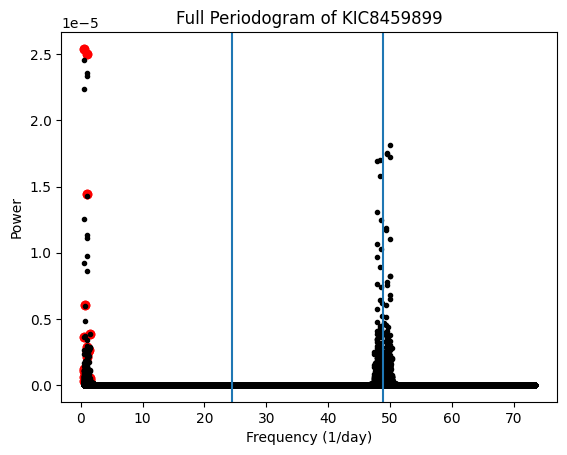

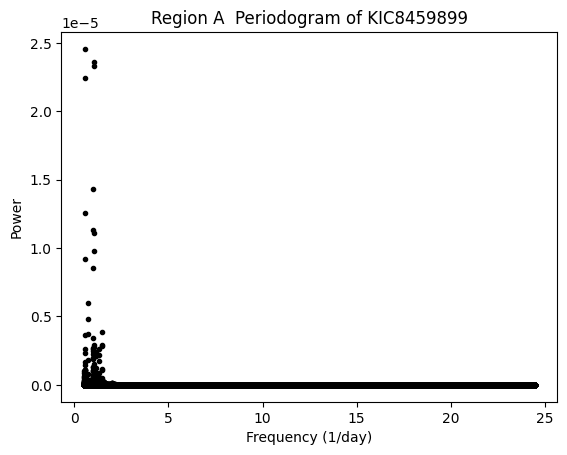

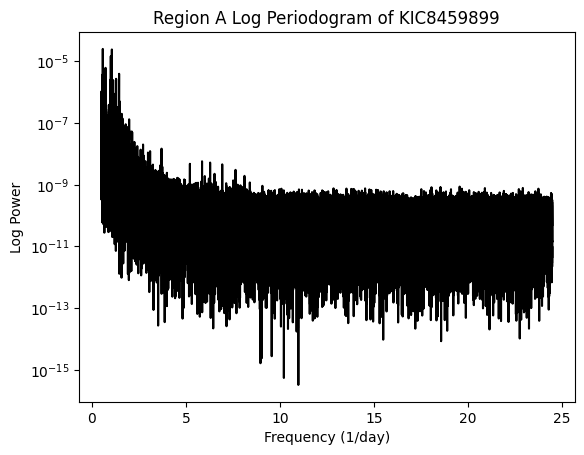

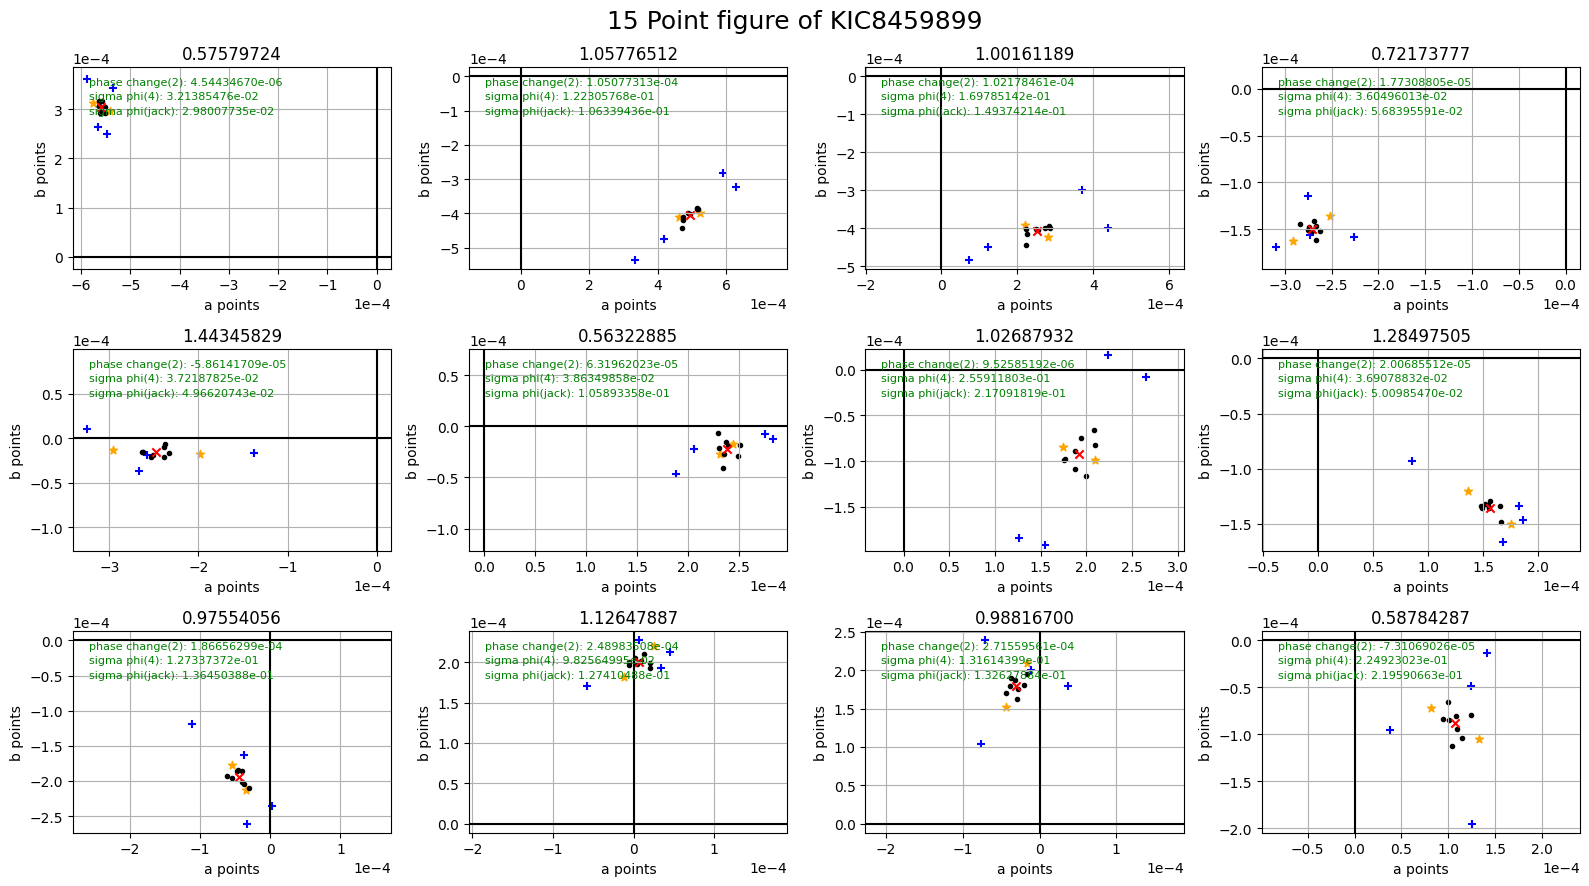

In [4]:
star_search(8459899, True, False)